In [74]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import warnings
import os
from pathlib import Path
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from analysis.risk_hypthesis_tester import RiskHypothesisTester
from utils.load_data import load_local_data

In [76]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [77]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🧱 1. Setup & Imports

In [78]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.csv')
df=pd.read_csv(file_path).drop('CustomValueEstimate',axis=1)
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,...,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,512.848070,0.0,Male
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male


In [79]:
df.columns.sort_values()

Index(['AccountType', 'AlarmImmobiliser', 'Bank', 'CalculatedPremiumPerTerm',
       'CapitalOutstanding', 'Citizenship', 'Converted', 'CoverCategory',
       'CoverGroup', 'CoverType', 'CrossBorder', 'Cylinders', 'ExcessSelected',
       'Gender_Inferred', 'IsVATRegistered', 'LegalType', 'MainCrestaZone',
       'MaritalStatus', 'Model', 'NewVehicle', 'NumberOfDoors', 'PolicyID',
       'PostalCode', 'Product', 'Province', 'Rebuilt', 'RegistrationYear',
       'Section', 'SubCrestaZone', 'SumInsured', 'TermFrequency', 'Title',
       'TotalClaims', 'TotalPremium', 'TrackingDevice', 'TransactionMonth',
       'UnderwrittenCoverID', 'VehicleIntroDate', 'VehicleType', 'WrittenOff',
       'bodytype', 'cubiccapacity', 'kilowatts', 'make', 'mmcode'],
      dtype='object')

In [80]:
#add a Margin, ClaimFrequency and ClaimSeverity to the df

df['Margin']=df['TotalPremium']-df['TotalClaims']
# Avoid divide-by-zero
df["ClaimSeverity"] = np.where(
    df["SumInsured"] > 0,
    df["TotalClaims"] / df["SumInsured"],
    0
)
df['ClaimFrequency']= (df['TotalClaims']>0).astype(int);

In [81]:
#rename the gender_inferred column

df=df.rename(columns={'Gender_Inferred':"Gender"})
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender', 'Margin',
       'ClaimSeverity', 'ClaimFrequency'],
      dtype='object')

In [82]:

# Initialize the tester
tester = RiskHypothesisTester(df)

### Accept or reject the following Null Hypotheses: 

    H₀:There are no risk differences across provinces 
    H₀:There are no risk differences between zip codes 
    H₀:There are no significant margin (profit) difference between zip codes 
    H₀:There are not significant risk difference between Women and Men

## A. 📍 Geographic Features

### Province

####  H₀:  There are no risk differences across provinces 

##### Check whether we can apply Parametric or non-Parametric Method

In [83]:
tester = RiskHypothesisTester(df)
tester.check_assumptions(group_col="Province", value_col="ClaimFrequency")


📊 Checking Assumptions for 'ClaimFrequency' grouped by 'Province':

🔍 Shapiro-Wilk Normality Test:
  Eastern Cape        : p = 0.0000 → ❌ Not Normal
  Free State          : p = 0.0000 → ❌ Not Normal
  Gauteng             : p = 0.0000 → ❌ Not Normal
  KwaZulu-Natal       : p = 0.0000 → ❌ Not Normal
  Limpopo             : p = 0.0000 → ❌ Not Normal
  Mpumalanga          : p = 0.0000 → ❌ Not Normal
  North West          : p = 0.0000 → ❌ Not Normal
  Northern Cape       : p = 0.0000 → ❌ Not Normal
  Western Cape        : p = 0.0000 → ❌ Not Normal

🧪 Levene’s Test for Equal Variance:
  Levene’s p = 0.0000 → ❌ Variance Not Equal


{'normality_p_values': {'Eastern Cape': 5.391367522248754e-148,
  'Free State': 7.848505147653476e-109,
  'Gauteng': 2.3347257330611732e-219,
  'KwaZulu-Natal': 2.053661869886028e-198,
  'Limpopo': 1.214948385152256e-141,
  'Mpumalanga': 1.4892969665084766e-164,
  'North West': 7.287786883993796e-194,
  'Northern Cape': 3.603050146775611e-102,
  'Western Cape': 9.221628632037399e-199},
 'levene_p_value': 2.690763875185085e-20}

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Conclusion:</font></h3>

* We will use a non-Parametric Method
</div>

[2025-06-13 19:31:33,897] INFO: Running chi-squared test for 'Province' vs 'ClaimFrequency'...
[2025-06-13 19:31:33,897] INFO: Running chi-squared test for 'Province' vs 'ClaimFrequency'...
[2025-06-13 19:31:33,897] INFO: Running chi-squared test for 'Province' vs 'ClaimFrequency'...
[2025-06-13 19:31:33,897] INFO: Running chi-squared test for 'Province' vs 'ClaimFrequency'...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for 'Province' vs 'ClaimFrequency'...


 Chi-Squared Test: Province vs ClaimFrequency  
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 110.7279               │
│ Degrees of Freedom │ 8                      │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

                      Group Details for 'Province'                      
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ Province      ┃ Count (0) ┃ Prop (0) ┃ Count (1) ┃ Prop (1) ┃  Total ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ Eastern Cape  │     30286 │   0.9984 │        50 │   0.0016 │  30336 │
│ Free State    │      8088 │   0.9986 │        11 │   0.0014 │   8099 │
│ Gauteng       │    392303 │   0.9966 │      1322 │   0.0034 │ 393625 │
│ KwaZulu-Natal │    169298 │   0.9972 │       483 │   0.0028 │ 169781 │
│ Limpopo       │     24769 │   0.9973 │        67 │   0.0027 │  24836 │
│ Mpumalanga    │     52510 │   0.9976 │       128 │   0.0024 │  52638 │
│ North West    │    142938 │   0.9976 │       349 │   0.0024 │ 143287 │
│ Northern Cape │      6372 │   0.9987 │         8 │   0.0013 │   6380 │
│ Western Cape  │    170205 │   0.9979 │       357 │   0.0021 │ 170562 │
└───────────────┴───────────┴──────────┴───────────┴──────────┴────────┘

[2025-06-13 19:31:34,049] INFO: Markdown report saved to reports/report_chi2_Province.md
[2025-06-13 19:31:34,049] INFO: Markdown report saved to reports/report_chi2_Province.md
[2025-06-13 19:31:34,049] INFO: Markdown report saved to reports/report_chi2_Province.md
[2025-06-13 19:31:34,049] INFO: Markdown report saved to reports/report_chi2_Province.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/report_chi2_Province.md
[2025-06-13 19:31:34,057] INFO: Visualizing ClaimFrequency by Province (bar plot)...
[2025-06-13 19:31:34,057] INFO: Visualizing ClaimFrequency by Province (bar plot)...
[2025-06-13 19:31:34,057] INFO: Visualizing ClaimFrequency by Province (bar plot)...
[2025-06-13 19:31:34,057] INFO: Visualizing ClaimFrequency by Province (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by Province (bar plot)...


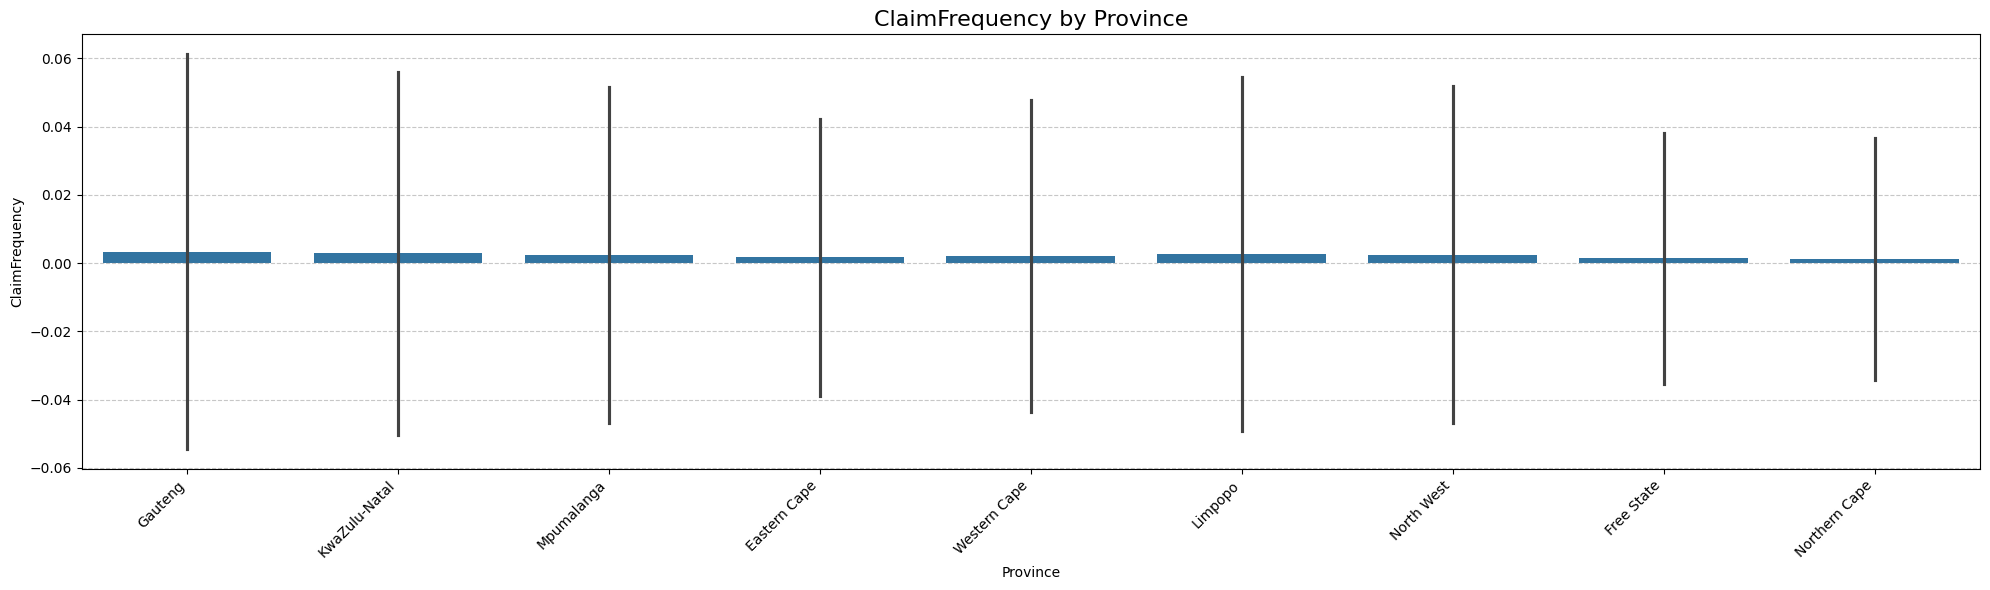

'We reject the null hypothesis that `Province` has no effect on `ClaimFrequency` (p = 0.0000). This indicates no statistically "significant" impact of `Province`'

In [84]:
chi2_result = tester.run_chi2("Province", binary_metric="ClaimFrequency")
tester.export_markdown_report(chi2_result, f"reports/report_chi2_{'Province'}.md")
tester.visualize_metric('Province', "ClaimFrequency", kind="bar")
tester.interpret_result(chi2_result)

### Postal/Zip Code

####   H₀  :    There are no risk differences between zip codes 

##### Check whether we can apply Parametric or non-Parametric Method

In [85]:
tester = RiskHypothesisTester(df)
tester.check_assumptions(group_col="PostalCode", value_col="ClaimFrequency")


📊 Checking Assumptions for 'ClaimFrequency' grouped by 'PostalCode':

🔍 Shapiro-Wilk Normality Test:
  1                   : p = 0.0000 → ❌ Not Normal
  2                   : p = 0.0000 → ❌ Not Normal
  4                   : p = 1.0000 → ✅ Normal
  5                   : p = 0.0000 → ❌ Not Normal
  6                   : p = 0.0000 → ❌ Not Normal
  7                   : p = 1.0000 → ✅ Normal
  8                   : p = 0.0000 → ❌ Not Normal
  17                  : p = 1.0000 → ✅ Normal
  21                  : p = 0.0000 → ❌ Not Normal
  22                  : p = 1.0000 → ✅ Normal
  29                  : p = 0.0000 → ❌ Not Normal
  31                  : p = 0.0000 → ❌ Not Normal
  35                  : p = 1.0000 → ✅ Normal
  37                  : p = 0.0000 → ❌ Not Normal
  44                  : p = 0.0000 → ❌ Not Normal
  46                  : p = 1.0000 → ✅ Normal
  49                  : p = 0.0000 → ❌ Not Normal
  54                  : p = 1.0000 → ✅ Normal
  64                  : p 

{'normality_p_values': {1: 4.2450994867432635e-97,
  2: 2.1372930348363976e-65,
  4: 1.0,
  5: 5.1068552246639505e-40,
  6: 5.007233746571688e-42,
  7: 1.0,
  8: 1.2861268156003814e-62,
  17: 1.0,
  21: 7.814813375034566e-41,
  22: 1.0,
  29: 8.554601882278937e-43,
  31: 9.389907818138616e-25,
  35: 1.0,
  37: 1.0158978244097468e-43,
  44: 1.2847522428675935e-39,
  46: 1.0,
  49: 3.3989619212287435e-24,
  54: 1.0,
  64: 2.0827742401179244e-36,
  66: 1.0,
  81: 1.0574260860018599e-48,
  84: 1.604285699541961e-50,
  101: 1.0,
  112: 1.0,
  116: 1.0,
  118: 1.0,
  120: 6.396545705018763e-70,
  121: 1.0,
  122: 4.908272242963658e-162,
  125: 1.735081606833169e-57,
  129: 1.0,
  132: 3.37114230535811e-22,
  139: 9.348010603727724e-23,
  143: 1.0,
  147: 1.0,
  149: 1.0,
  151: 1.0,
  152: 1.0094429656694655e-112,
  153: 2.541090455641869e-34,
  154: 1.0,
  157: 3.741783158889171e-52,
  161: 6.108650910628096e-43,
  162: 2.739458173773589e-86,
  164: 1.6662592058697365e-55,
  168: 1.0,
  172

##### Check whether we can apply Parametric or non-Parametric Method

In [86]:
tester = RiskHypothesisTester(df)
tester.check_assumptions(group_col="PostalCode", value_col="ClaimFrequency")


📊 Checking Assumptions for 'ClaimFrequency' grouped by 'PostalCode':

🔍 Shapiro-Wilk Normality Test:
  1                   : p = 0.0000 → ❌ Not Normal
  2                   : p = 0.0000 → ❌ Not Normal
  4                   : p = 1.0000 → ✅ Normal
  5                   : p = 0.0000 → ❌ Not Normal
  6                   : p = 0.0000 → ❌ Not Normal
  7                   : p = 1.0000 → ✅ Normal
  8                   : p = 0.0000 → ❌ Not Normal
  17                  : p = 1.0000 → ✅ Normal
  21                  : p = 0.0000 → ❌ Not Normal
  22                  : p = 1.0000 → ✅ Normal
  29                  : p = 0.0000 → ❌ Not Normal
  31                  : p = 0.0000 → ❌ Not Normal
  35                  : p = 1.0000 → ✅ Normal
  37                  : p = 0.0000 → ❌ Not Normal
  44                  : p = 0.0000 → ❌ Not Normal
  46                  : p = 1.0000 → ✅ Normal
  49                  : p = 0.0000 → ❌ Not Normal
  54                  : p = 1.0000 → ✅ Normal
  64                  : p 

{'normality_p_values': {1: 4.2450994867432635e-97,
  2: 2.1372930348363976e-65,
  4: 1.0,
  5: 5.1068552246639505e-40,
  6: 5.007233746571688e-42,
  7: 1.0,
  8: 1.2861268156003814e-62,
  17: 1.0,
  21: 7.814813375034566e-41,
  22: 1.0,
  29: 8.554601882278937e-43,
  31: 9.389907818138616e-25,
  35: 1.0,
  37: 1.0158978244097468e-43,
  44: 1.2847522428675935e-39,
  46: 1.0,
  49: 3.3989619212287435e-24,
  54: 1.0,
  64: 2.0827742401179244e-36,
  66: 1.0,
  81: 1.0574260860018599e-48,
  84: 1.604285699541961e-50,
  101: 1.0,
  112: 1.0,
  116: 1.0,
  118: 1.0,
  120: 6.396545705018763e-70,
  121: 1.0,
  122: 4.908272242963658e-162,
  125: 1.735081606833169e-57,
  129: 1.0,
  132: 3.37114230535811e-22,
  139: 9.348010603727724e-23,
  143: 1.0,
  147: 1.0,
  149: 1.0,
  151: 1.0,
  152: 1.0094429656694655e-112,
  153: 2.541090455641869e-34,
  154: 1.0,
  157: 3.741783158889171e-52,
  161: 6.108650910628096e-43,
  162: 2.739458173773589e-86,
  164: 1.6662592058697365e-55,
  168: 1.0,
  172

[2025-06-13 19:31:38,894] INFO: Running chi-squared test for 'PostalCode' vs 'ClaimFrequency'...
[2025-06-13 19:31:38,894] INFO: Running chi-squared test for 'PostalCode' vs 'ClaimFrequency'...
[2025-06-13 19:31:38,894] INFO: Running chi-squared test for 'PostalCode' vs 'ClaimFrequency'...
[2025-06-13 19:31:38,894] INFO: Running chi-squared test for 'PostalCode' vs 'ClaimFrequency'...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for 'PostalCode' vs 'ClaimFrequency'...


Chi-Squared Test: PostalCode vs ClaimFrequency 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 1451.6755              │
│ Degrees of Freedom │ 887                    │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

                   Group Details for 'PostalCode'                    
┏━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ PostalCode ┃ Count (0) ┃ Prop (0) ┃ Count (1) ┃ Prop (1) ┃  Total ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 1          │      5329 │   0.9978 │        12 │   0.0022 │   5341 │
│ 2          │      1482 │   0.9960 │         6 │   0.0040 │   1488 │
│ 4          │        77 │   1.0000 │         0 │   0.0000 │     77 │
│ 5          │       396 │   0.9900 │         4 │   0.0100 │    400 │
│ 6          │       438 │   0.9955 │         2 │   0.0045 │    440 │
│ 7          │       356 │   1.0000 │         0 │   0.0000 │    356 │
│ 8          │      1278 │   0.9992 │         1 │   0.0008 │   1279 │
│ 17         │       160 │   1.0000 │         0 │   0.0000 │    160 │
│ 21         │       412 │   0.9928 │         3 │   0.0072 │    415 │
│ 22         │       605 │   1.0000 │         0 │   0.0000 │    605 │
│ 29         │       453 │   0.9978 │         1 │   0.0022 │    454 │
│ 31         │       132 │   0.9778 │         3 │   0.0222 │    135 │
│ 35         │       343 │   1.0000 │         0 │   0.0000 │    343 │
│ 37         │       484 │   0.9959 │         2 │   0.0041 │    486 │
│ 44         │       373 │   0.9973 │         1 │   0.0027 │    374 │
│ 46         │        22 │   1.0000 │         0 │   0.0000 │     22 │
│ 49         │       119 │   0.9917 │         1 │   0.0083 │    120 │
│ 54         │       230 │   1.0000 │         0 │   0.0000 │    230 │
│ 64         │       308 │   0.9935 │         2 │   0.0065 │    310 │
│ 66         │       216 │   1.0000 │         0 │   0.0000 │    216 │
│ 81         │       662 │   0.9895 │         7 │   0.0105 │    669 │
│ 84         │       700 │   0.9986 │         1 │   0.0014 │    701 │
│ 101        │       181 │   1.0000 │         0 │   0.0000 │    181 │
│ 112        │        50 │   1.0000 │         0 │   0.0000 │     50 │
│ 116        │       100 │   1.0000 │         0 │   0.0000 │    100 │
│ 118        │       156 │   1.0000 │         0 │   0.0000 │    156 │
│ 120        │      1813 │   0.9962 │         7 │   0.0038 │   1820 │
│ 121        │       100 │   1.0000 │         0 │   0.0000 │    100 │
│ 122        │     48961 │   0.9957 │       210 │   0.0043 │  49171 │
│ 125        │      1031 │   0.9933 │         7 │   0.0067 │   1038 │
│ 129        │       510 │   1.0000 │         0 │   0.0000 │    510 │
│ 132        │        99 │   0.9900 │         1 │   0.0100 │    100 │
│ 139        │       108 │   0.9818 │         2 │   0.0182 │    110 │
│ 143        │       250 │   1.0000 │         0 │   0.0000 │    250 │
│ 147        │       214 │   1.0000 │         0 │   0.0000 │    214 │
│ 149        │        50 │   1.0000 │         0 │   0.0000 │     50 │
│ 151        │       360 │   1.0000 │         0 │   0.0000 │    360 │
│ 152        │      9391 │   0.9966 │        32 │   0.0034 │   9423 │
│ 153        │       263 │   0.9962 │         1 │   0.0038 │    264 │
│ 154        │       192 │   1.0000 │         0 │   0.0000 │    192 │
│ 157        │       792 │   0.9912 │         7 │   0.0088 │    799 │
│ 161        │       467 │   0.9936 │         3 │   0.0064 │    470 │
│ 162        │      3546 │   0.9972 │        10 │   0.0028 │   3556 │
│ 164        │       906 │   0.9989 │         1 │   0.0011 │    907 │
│ 168        │       585 │   1.0000 │         0 │   0.0000 │    585 │
│ 172        │       380 │   1.0000 │         0 │   0.0000 │    380 │
│ 175        │       478 │   0.9958 │         2 │   0.0042 │    480 │
│ 177        │      1353 │   0.9941 │         8 │   0.0059 │   1361 │
│ 179        │       921 │   0.9935 │         6 │   0.0065 │    927 │
│ 181        │       154 │   0.9747 │         4 │   0.0253 │    158 │
│ 182        │      1655 │   0.9946 │         9 │   0.0054 │   1664 │
│ 183        │      2502 │   0.9948 │        13 │   0.0052 │   2515 │
│ 184        │       395 │   0.9950 │         2 │   0.0050 │    397 │
│ 186     

[2025-06-13 19:31:39,820] INFO: Markdown report saved to reports/report_chi2_PostalCode.md
[2025-06-13 19:31:39,820] INFO: Markdown report saved to reports/report_chi2_PostalCode.md
[2025-06-13 19:31:39,820] INFO: Markdown report saved to reports/report_chi2_PostalCode.md
[2025-06-13 19:31:39,820] INFO: Markdown report saved to reports/report_chi2_PostalCode.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/report_chi2_PostalCode.md
[2025-06-13 19:31:39,826] INFO: Visualizing ClaimFrequency by PostalCode (bar plot)...
[2025-06-13 19:31:39,826] INFO: Visualizing ClaimFrequency by PostalCode (bar plot)...
[2025-06-13 19:31:39,826] INFO: Visualizing ClaimFrequency by PostalCode (bar plot)...
[2025-06-13 19:31:39,826] INFO: Visualizing ClaimFrequency by PostalCode (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by PostalCode (bar plot)...
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as fl

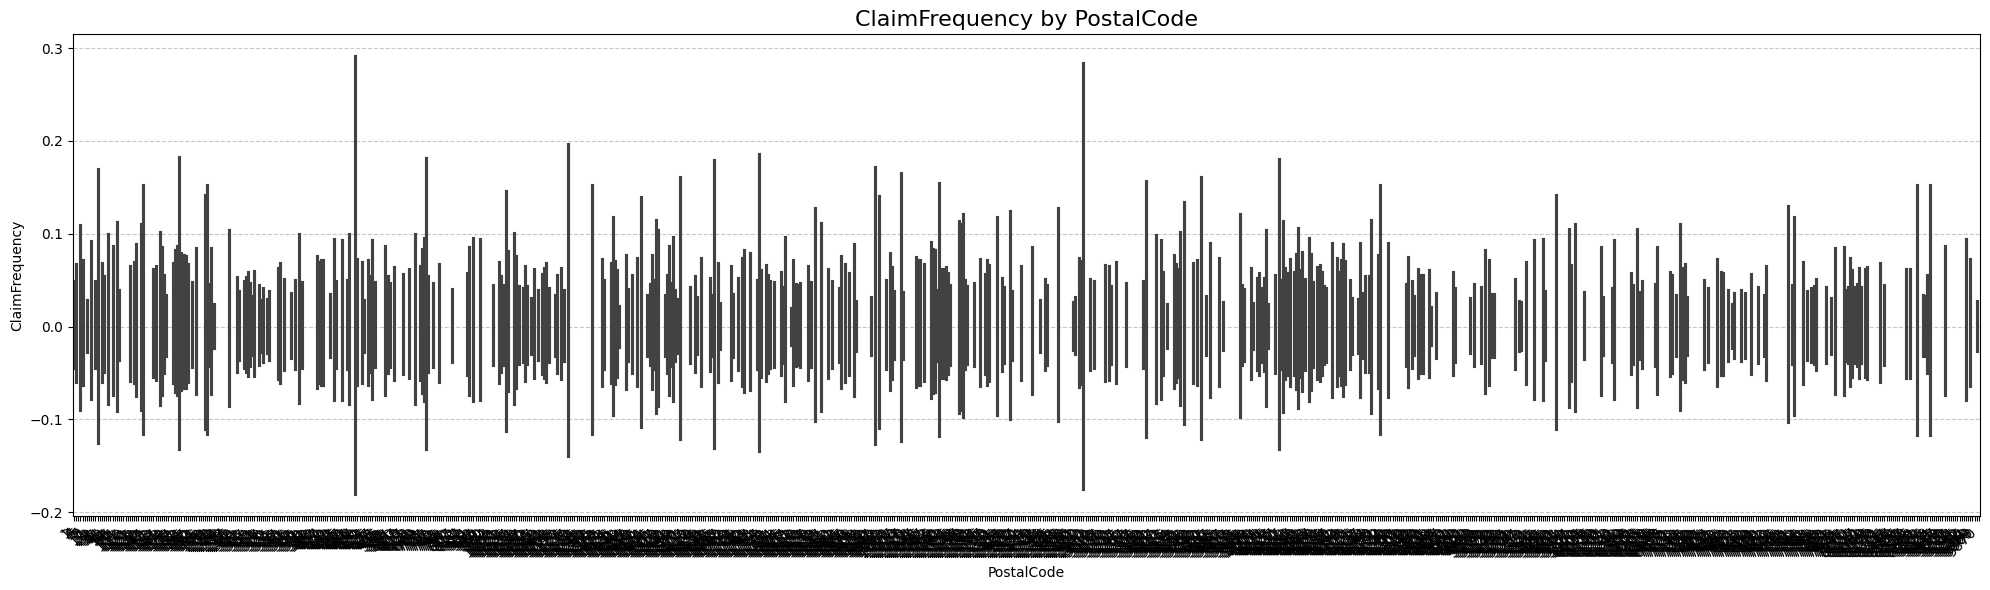

'We reject the null hypothesis that `PostalCode` has no effect on `ClaimFrequency` (p = 0.0000). This indicates no statistically "significant" impact of `PostalCode`'

In [87]:
chi2_result = tester.run_chi2("PostalCode", binary_metric="ClaimFrequency")
tester.export_markdown_report(chi2_result, f"reports/report_chi2_{'PostalCode'}.md")
tester.visualize_metric('PostalCode', "ClaimFrequency", kind="bar")
tester.interpret_result(chi2_result)

####   H₀   :  There are no significant margin (profit) difference between zip codes 

In [88]:
tester = RiskHypothesisTester(df)
tester.test_numeric_by_group_kruskal(group_col='PostalCode',numeric_col="Margin")


🔍 Kruskal-Wallis Test: 'Margin' across 'PostalCode' groups...
✅ Kruskal-Wallis H-statistic = 88676.0408
📊 P-value = 0.0000 → Reject H₀ (Differences exist)
🧮 Groups compared: 857


{'p_value': 0.0, 'statistic': 88676.0407999158, 'groups_used': 857}

###  MainCrestaZone & SubCrestaZone

[2025-06-13 19:31:50,157] INFO: Running chi-squared test for 'MainCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:50,157] INFO: Running chi-squared test for 'MainCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:50,157] INFO: Running chi-squared test for 'MainCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:50,157] INFO: Running chi-squared test for 'MainCrestaZone' vs 'ClaimFrequency'...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for 'MainCrestaZone' vs 'ClaimFrequency'...


      Chi-Squared Test: MainCrestaZone vs      
                ClaimFrequency                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 182.0177               │
│ Degrees of Freedom │ 15                     │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

                                  Group Details for 'MainCrestaZone'                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ MainCrestaZone                              ┃ Count (0) ┃ Prop (0) ┃ Count (1) ┃ Prop (1) ┃  Total ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ Cape Province                               │      6692 │   0.9987 │         9 │   0.0013 │   6701 │
│ Cape Province (Cape Town)                   │     95493 │   0.9978 │       209 │   0.0022 │  95702 │
│ Cape Province (East and North of Cape Town) │     19341 │   0.9974 │        50 │   0.0026 │  19391 │
│ Ciskei, Cape Mid 1                          │      2410 │   0.9979 │         5 │   0.0021 │   2415 │
│ East London                                 │      3957 │   0.9990 │         4 │   0.0010 │   3961 │
│ Johannesburg                                │    175152 │   0.9964 │       628 │   0.0036 │ 175780 │
│ Karoo 1 (Northeast of Cape Town)            │     52639 │   0.9982 │        93 │   0.0018 │  52732 │
│ Langkloof, Coast 2, Coast 1                 │      3004 │   0.9983 │         5 │   0.0017 │   3009 │
│ Natal                                       │     88065 │   0.9977 │       201 │   0.0023 │  88266 │
│ Natal (Durban)                              │     82576 │   0.9966 │       283 │   0.0034 │  82859 │
│ Oranje Free State                           │      8138 │   0.9987 │        11 │   0.0013 │   8149 │
│ Port Elizabeth                              │      1781 │   0.9994 │         1 │   0.0006 │   1782 │
│ Rand East                                   │     42076 │   0.9978 │        92 │   0.0022 │  42168 │
│ Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1 │     20153 │   0.9981 │        38 │   0.0019 │  20191 │
│ Transvaal (Pretoria)                        │     99933 │   0.9960 │       398 │   0.0040 │ 100331 │
│ Transvaal (all except Pretoria)             │    295359 │   0.9975 │       748 │   0.0025 │ 296107 │
└─────────────────────────────────────────────┴───────────┴──────────┴───────────┴──────────┴────────┘

[2025-06-13 19:31:50,357] INFO: Markdown report saved to reports/report_chi2_MainCrestaZone.md
[2025-06-13 19:31:50,357] INFO: Markdown report saved to reports/report_chi2_MainCrestaZone.md
[2025-06-13 19:31:50,357] INFO: Markdown report saved to reports/report_chi2_MainCrestaZone.md
[2025-06-13 19:31:50,357] INFO: Markdown report saved to reports/report_chi2_MainCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/report_chi2_MainCrestaZone.md
[2025-06-13 19:31:50,363] INFO: Visualizing ClaimFrequency by MainCrestaZone (bar plot)...
[2025-06-13 19:31:50,363] INFO: Visualizing ClaimFrequency by MainCrestaZone (bar plot)...
[2025-06-13 19:31:50,363] INFO: Visualizing ClaimFrequency by MainCrestaZone (bar plot)...
[2025-06-13 19:31:50,363] INFO: Visualizing ClaimFrequency by MainCrestaZone (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by MainCrestaZone (bar plot)...


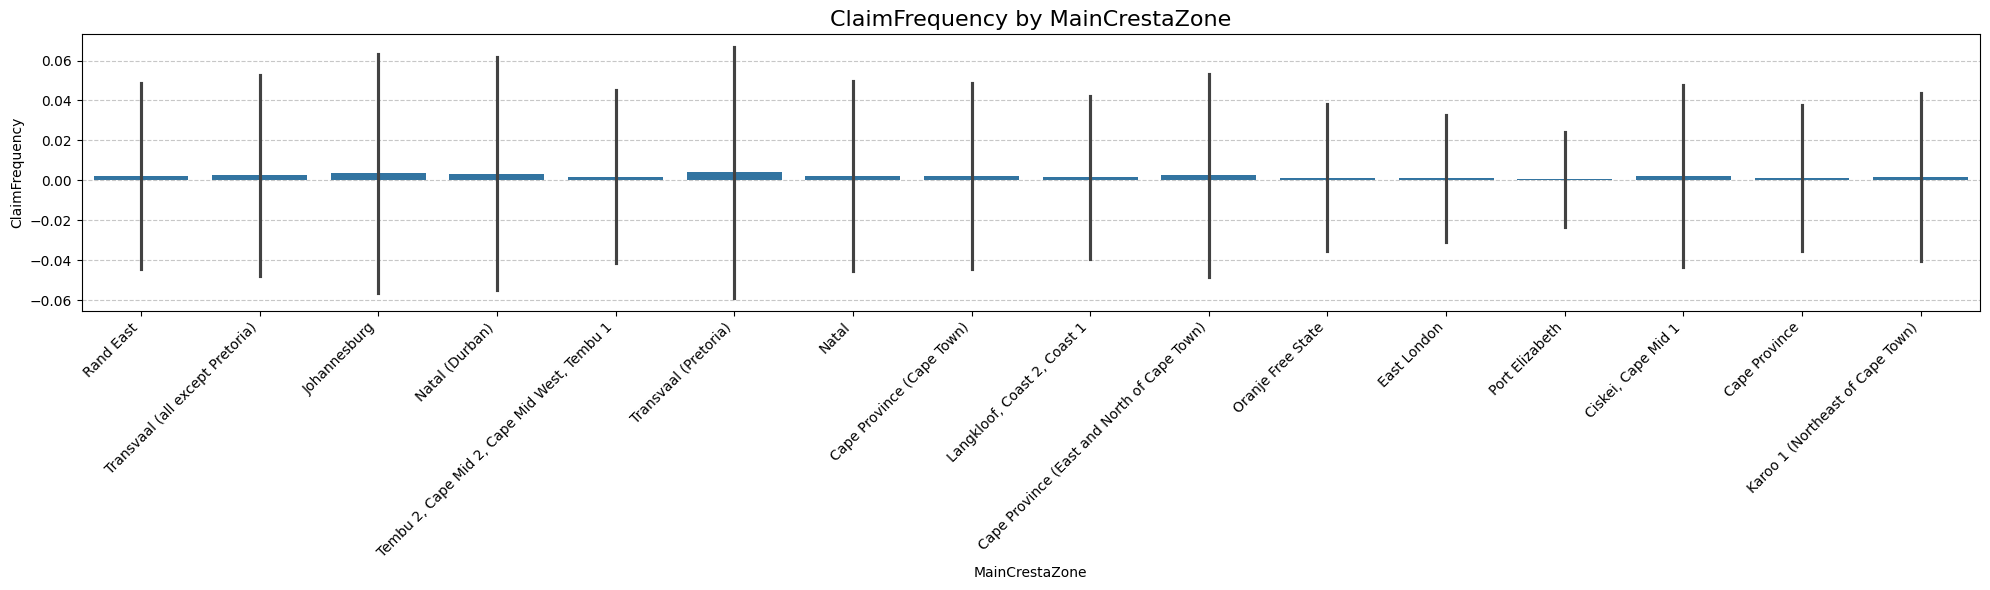

[2025-06-13 19:31:52,743] INFO: Running chi-squared test for 'SubCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:52,743] INFO: Running chi-squared test for 'SubCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:52,743] INFO: Running chi-squared test for 'SubCrestaZone' vs 'ClaimFrequency'...
[2025-06-13 19:31:52,743] INFO: Running chi-squared test for 'SubCrestaZone' vs 'ClaimFrequency'...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for 'SubCrestaZone' vs 'ClaimFrequency'...


      Chi-Squared Test: SubCrestaZone vs       
                ClaimFrequency                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 226.9811               │
│ Degrees of Freedom │ 44                     │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

                       Group Details for 'SubCrestaZone'                       
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃ SubCrestaZone        ┃ Count (0) ┃ Prop (0) ┃ Count (1) ┃ Prop (1) ┃  Total ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ Bloemfontein         │      3589 │   0.9986 │         5 │   0.0014 │   3594 │
│ Bushveld             │     19224 │   0.9985 │        29 │   0.0015 │  19253 │
│ Cape Mid 1           │       603 │   0.9983 │         1 │   0.0017 │    604 │
│ Cape Mid 2           │       403 │   1.0000 │         0 │   0.0000 │    403 │
│ Cape Mid West        │      7193 │   0.9976 │        17 │   0.0024 │   7210 │
│ Cape Town            │     95493 │   0.9978 │       209 │   0.0022 │  95702 │
│ Ciskei               │      1807 │   0.9978 │         4 │   0.0022 │   1811 │
│ Coast 1              │       224 │   1.0000 │         0 │   0.0000 │    224 │
│ Coast 2              │      2188 │   0.9982 │         4 │   0.0018 │   2192 │
│ Drakensberg          │      3763 │   0.9987 │         5 │   0.0013 │   3768 │
│ Durban               │     82576 │   0.9966 │       283 │   0.0034 │  82859 │
│ East London          │      3957 │   0.9990 │         4 │   0.0010 │   3961 │
│ East and North of    │     19341 │   0.9974 │        50 │   0.0026 │  19391 │
│ Herbert              │        36 │   1.0000 │         0 │   0.0000 │     36 │
│ Highveld             │      1005 │   0.9960 │         4 │   0.0040 │   1009 │
│ Johannesburg         │    175152 │   0.9964 │       628 │   0.0036 │ 175780 │
│ Kalahari             │      2733 │   0.9989 │         3 │   0.0011 │   2736 │
│ Karoo 1              │      1344 │   0.9985 │         2 │   0.0015 │   1346 │
│ Karoo 2              │       320 │   0.9969 │         1 │   0.0031 │    321 │
│ Langkloof            │       592 │   0.9983 │         1 │   0.0017 │    593 │
│ Namakwa              │      1681 │   0.9994 │         1 │   0.0006 │   1682 │
│ Natal 1              │      4827 │   0.9969 │        15 │   0.0031 │   4842 │
│ Natal 2              │      6832 │   0.9980 │        14 │   0.0020 │   6846 │
│ Natal 3              │     16256 │   0.9974 │        43 │   0.0026 │  16299 │
│ Natal Cape           │       941 │   0.9989 │         1 │   0.0011 │    942 │
│ North Coast          │     30094 │   0.9980 │        60 │   0.0020 │  30154 │
│ Northeast of CT      │     51295 │   0.9982 │        91 │   0.0018 │  51386 │
│ OFS North 1 and      │       786 │   0.9987 │         1 │   0.0013 │    787 │
│ Pondo                │      1784 │   0.9994 │         1 │   0.0006 │   1785 │
│ Port Elizabeth       │      1781 │   0.9994 │         1 │   0.0006 │   1782 │
│ Pretoria             │     99933 │   0.9960 │       398 │   0.0040 │ 100331 │
│ Rand East            │     42076 │   0.9978 │        92 │   0.0022 │  42168 │
│ Rand West            │     22417 │   0.9973 │        61 │   0.0027 │  22478 │
│ South Coast          │     17534 │   0.9969 │        54 │   0.0031 │  17588 │
│ Tembu 1              │      9153 │   0.9987 │        12 │   0.0013 │   9165 │
│ Tembu 2              │      3404 │   0.9974 │         9 │   0.0026 │   3413 │
│ Transvaal East       │     45535 │   0.9975 │       114 │   0.0025 │  45649 │
│ Transvaal Mid West   │      5098 │   0.9986 │         7 │   0.0014 │   5105 │
│ Transvaal North      │     74908 │   0.9969 │       233 │   0.0031 │  75141 │
│ Transvaal North West │     72404 │   0.9979 │       154 │   0.0021 │  72558 │
│ Transvaal South      │     45441 │   0.9971 │       130 │   0.0029 │  45571 │
│ Transvaal South East │      5970 │   0.9983 │        10 │   0.0017 │   5980 │
│ Transvaal South West │      3357 │   0.9982 │         6 │   0.0018 │   3363 │
│ Vaalhartz            │      1922 │   0.9979 │         4 │   0.0021 │   1926 │
│ Zululand             │      9797 │   0.9987 │        13 │   0.0013 │   9810 │
└──────────────────────┴───────────┴──────────┴───────────┴──────────┴────────┘

[2025-06-13 19:31:52,957] INFO: Markdown report saved to reports/report_chi2_SubCrestaZone.md
[2025-06-13 19:31:52,957] INFO: Markdown report saved to reports/report_chi2_SubCrestaZone.md
[2025-06-13 19:31:52,957] INFO: Markdown report saved to reports/report_chi2_SubCrestaZone.md
[2025-06-13 19:31:52,957] INFO: Markdown report saved to reports/report_chi2_SubCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/report_chi2_SubCrestaZone.md
[2025-06-13 19:31:52,964] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 19:31:52,964] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 19:31:52,964] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 19:31:52,964] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by SubCrestaZone (bar plot)...


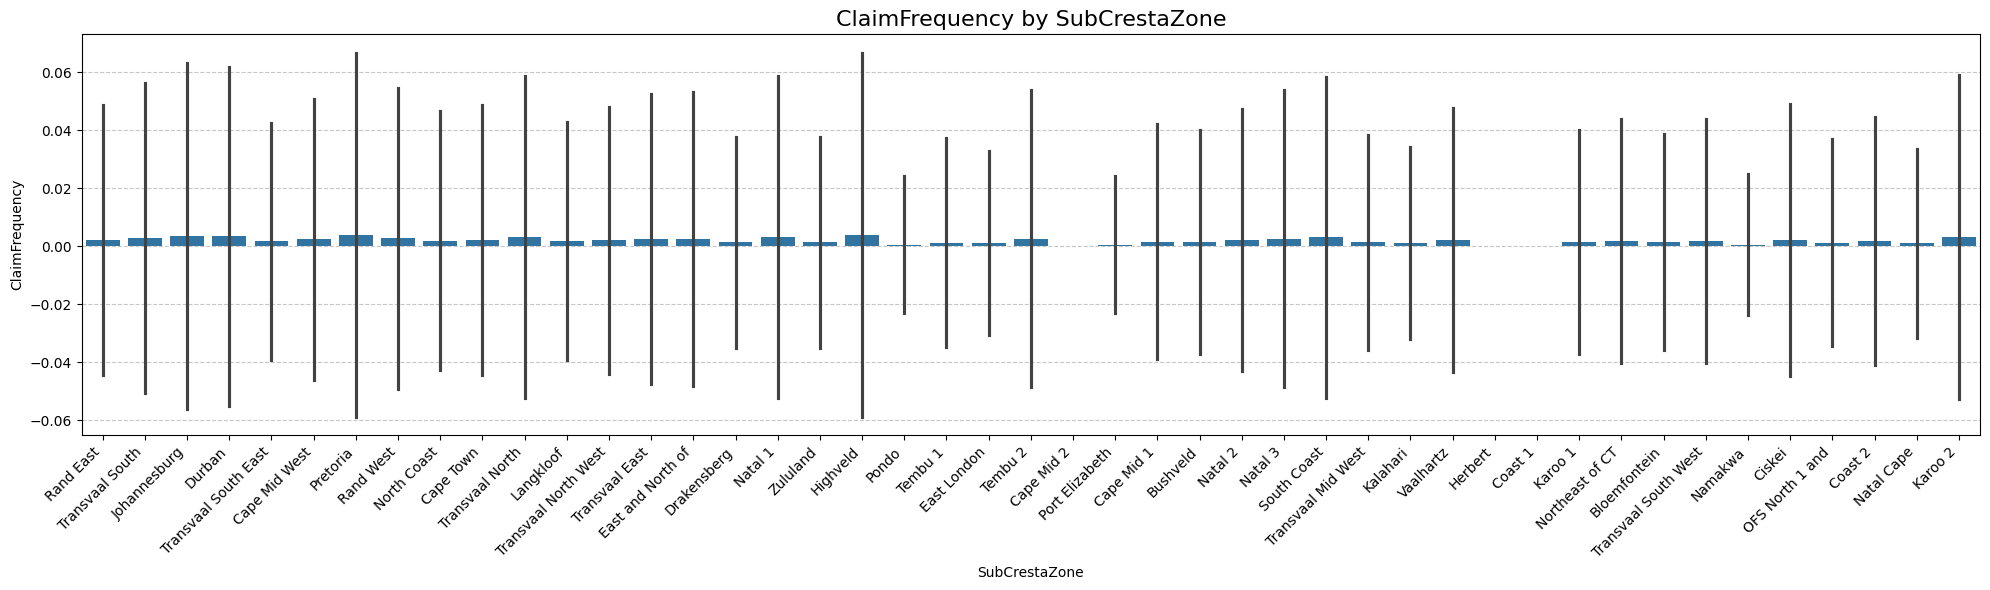

In [89]:
geo_features = ['MainCrestaZone', 'SubCrestaZone']

for feature in geo_features:
    try:
        chi2_result = tester.run_chi2(feature, binary_metric="ClaimFrequency")
        tester.export_markdown_report(chi2_result, f"reports/report_chi2_{feature}.md")
        tester.visualize_metric(feature, "ClaimFrequency", kind="bar")
        tester.interpret_result(chi2_result)
    except Exception as e:
        print(f"Chi-squared test failed for {feature}: {e}")


## B. 👨‍👩‍👧 Demographic Features

### Gender

 ###    H₀  :   There are not significant risk difference between Women and Men

##### Check whether we can apply Parametric or non-Parametric Method

In [90]:
tester = RiskHypothesisTester(df)
# tester.check_assumptions(group_col="Gender", value_col="ClaimFrequency")
tester.test_two_group_difference(group_col="Gender",numeric_col="Margin")

{'statistic': 31301780063.0,
 'p_value': 1.4331562081951986e-18,
 'basic_interpretation': 'Reject H₀ (statistically significant difference, p=0.0000)',
 'detailed_interpretation': 'Male exhibits a 127.3% lower average Margin compared to Female, suggesting a potential need for risk or pricing adjustment.',
 'group_1': 'Male',
 'group_2': 'Female',
 'mean_group_1': -4.279311086796271,
 'mean_group_2': 15.66324453578845,
 'diff_percent': -127.32071938874864,
 'n1': 933812,
 'n2': 65732}

In [91]:
# Define columns
group_col = 'Gender'
metric_col = 'TotalClaims'


In [92]:
df['Gender'].value_counts()

Gender
Male      933812
Female     65732
Name: count, dtype: int64

In [93]:
# Run the test
result=tester.test_two_group_difference(group_col="Gender", numeric_col="ClaimFrequency")


In [94]:
# View result
print(result)

{'statistic': 30716897982.0, 'p_value': 5.6835399108884613e-05, 'basic_interpretation': 'Reject H₀ (statistically significant difference, p=0.0001)', 'detailed_interpretation': 'Male exhibits a 43.2% higher average ClaimFrequency compared to Female, suggesting a potential need for risk or pricing adjustment.', 'group_1': 'Male', 'group_2': 'Female', 'mean_group_1': 0.0028324759159231196, 'mean_group_2': 0.0019777277429562467, 'diff_percent': 43.218697619583445, 'n1': 933812, 'n2': 65732}


[2025-06-13 19:31:56,806] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 19:31:56,806] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 19:31:56,806] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 19:31:56,806] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by Gender (bar plot)...


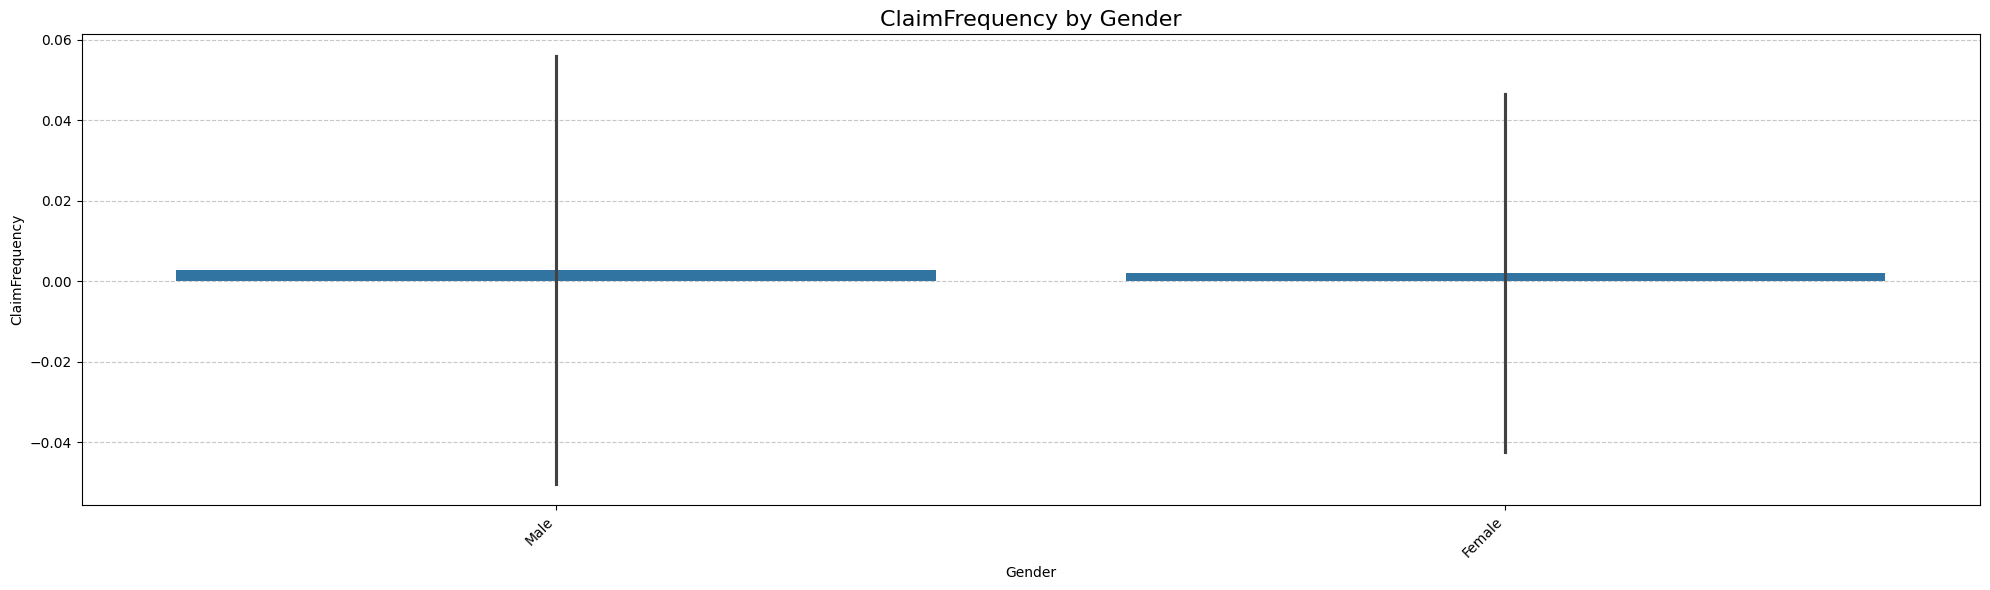

In [95]:
tester.visualize_metric('Gender', "ClaimFrequency", kind="bar")

In [96]:
tester.interpret_result(result)

'We reject the null hypothesis that `None` has no effect on `None` (p = 0.0001). This indicates no statistically "significant" impact of `None`'

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Conclusion:</font></h3>

* 'We reject the null hypothesis that `Gender` has no effect on `TotalClaims` (p = 0.0244). This suggests that `Gender` is a significant factor affecting `TotalClaims`. Consider using it in segmentation strategy or premium pricing.'
</div>

In [97]:
tester.export_markdown_report(result,'reports/hypothesis_report.md')

[2025-06-13 19:31:58,675] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 19:31:58,675] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 19:31:58,675] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 19:31:58,675] INFO: Markdown report saved to reports/hypothesis_report.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/hypothesis_report.md
